Lab 1: **Denoising the image with Deep Neural Network**
Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to illustrate how to utilize the Deep Neural Network to denoise the image.

In this class, you will learn

1. How to generate the noise and add it on image in pytorch

2. How to set the parameters for the model and build new model.

3. How to build the structure for training the model and evaluate the result

In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
Load github resource
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289 (from 1)
Receiving objects: 100% (289/289), 24.28 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (155/155), done.


**Set up the parameters of Gaussian noise**

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True

# Parameters of the Noise
sigma = 25
sigma_ = sigma/255.

**Choose the image for baseline**

In [ ]:
## denoising
fname = 'data/denoising/F16_GT.png'

**Load the original image and that with noise**

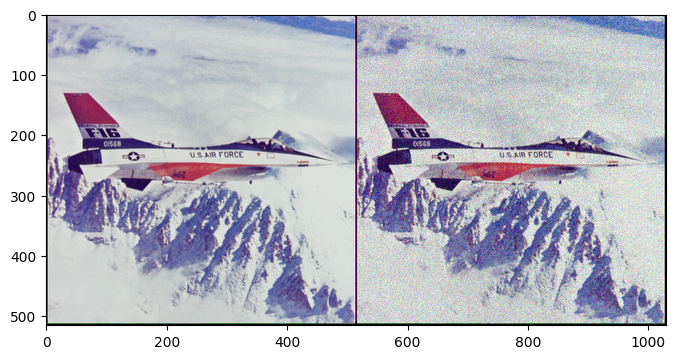

In [ ]:

# Add synthetic noise(Gaussin)
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);

**Set up the parameters for training**

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

#training parameters
reg_noise_std = 1./30.
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 3000
input_depth = 3
figsize = 4
random_noise = False

#Network structure
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# whether to generate random noise or noisy image
if random_noise:
    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
else:
    net_input = np_to_torch(img_noisy_np).type(dtype)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_torch = np_to_torch(img_np).type(dtype)

Number of params: 2184307


**Denoising with Neural Network**

Starting optimization with ADAM


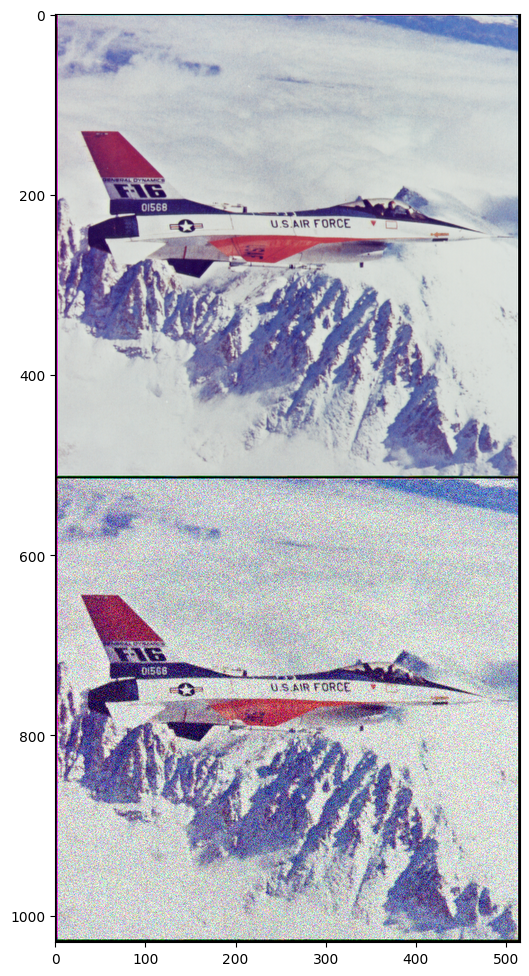

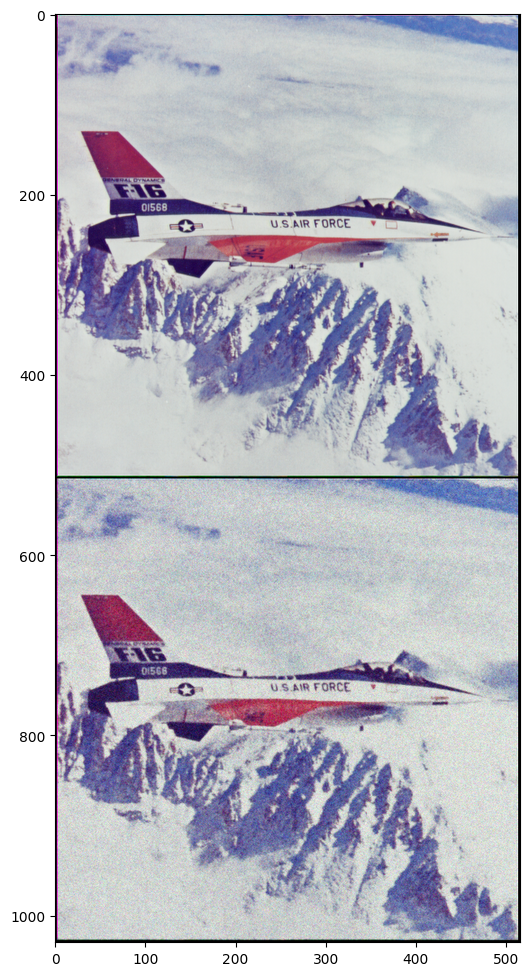

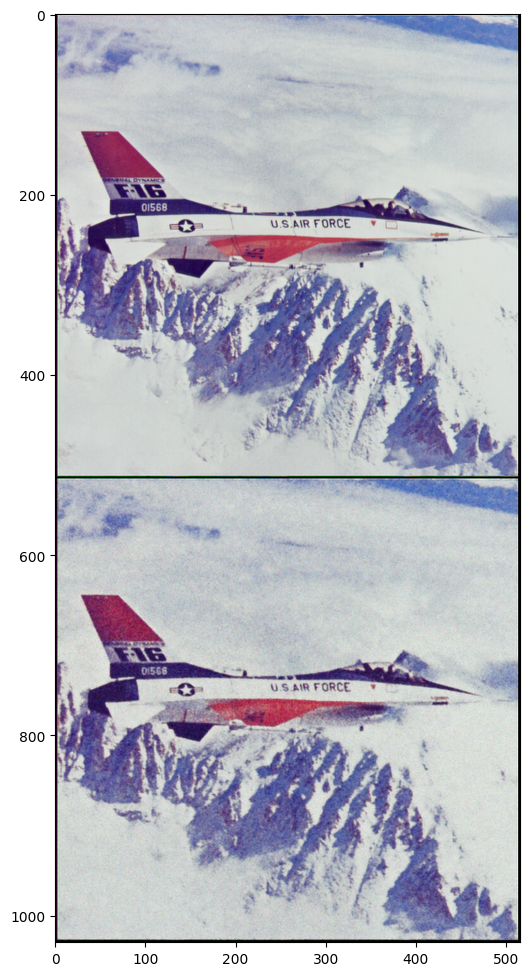

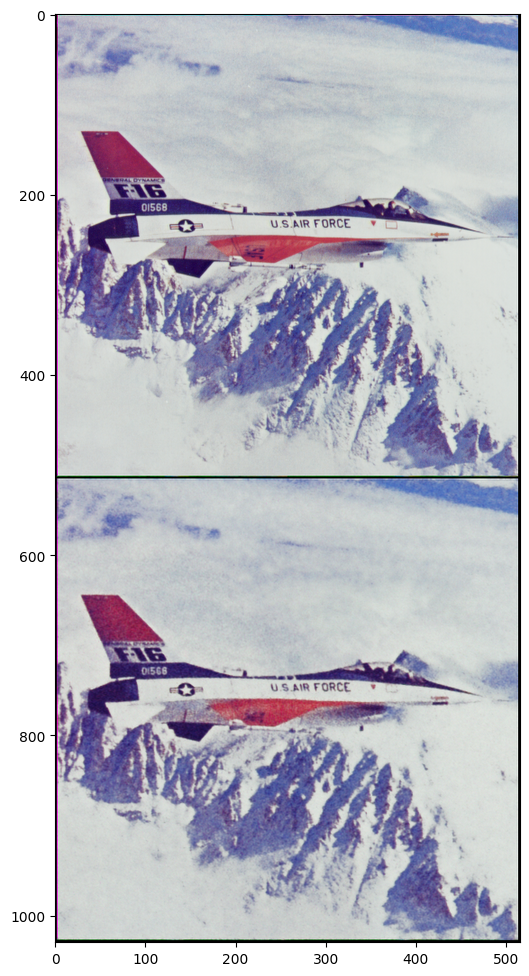

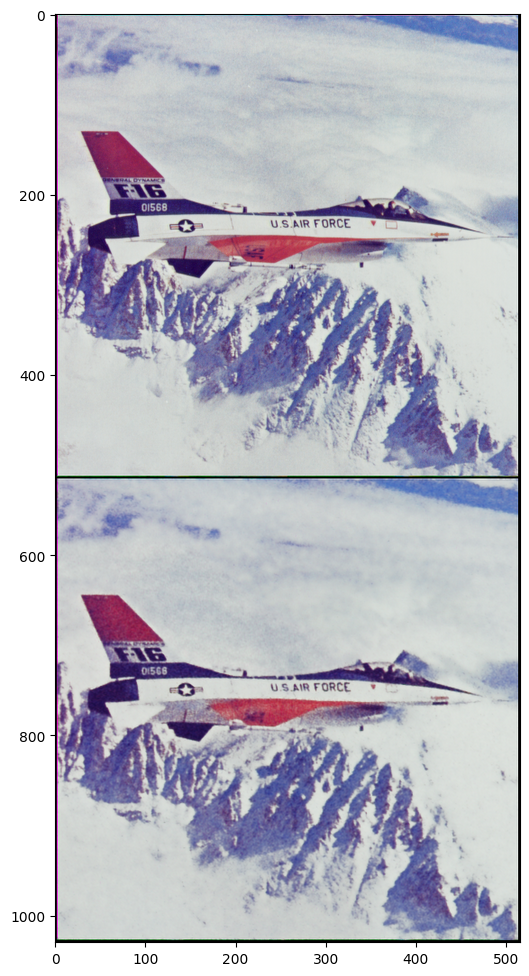

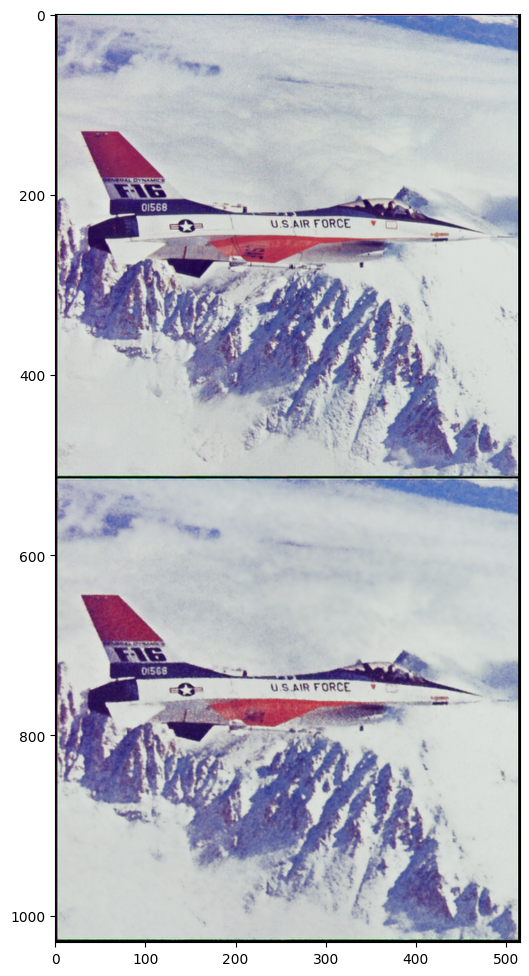

KeyboardInterrupt: 

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
#smoothing image
out_avg = net_input_saved

#without smoothing
#out_avg = None

last_net = None
psrn_noisy_last = 0

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    #total_loss = mse(out, img_noisy_torch)
    total_loss = mse(out, img_torch)
    total_loss.backward()

    #evaluation with psrn
    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])


    print('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        #out_np = torch_to_np(out)
        plot_image_grid([np.clip(img_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)



    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

**Show the result**

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);